In [1]:
import pandas as pd
import os
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import transforms as tr

In [2]:
import torch
import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 1.6.0
No GPU :(


In [3]:
# Get train and test images names
df_train_images = pd.read_csv('./flickr8k/annotations/trainImages.csv', names=['filename'])
df_test_images = pd.read_csv('./flickr8k/annotations/testImages.csv', names=['filename'])

print(f"Train shape: {df_train_images.shape}")
print(f"Test shape: {df_test_images.shape}")

Train shape: (6000, 1)
Test shape: (1000, 1)


In [4]:
# Split images in train and test folders
# 6000 train images and 1000 test images

imagesPath = './flickr8k/images/'
trainPath = imagesPath + 'train/'
testPath = imagesPath + 'test/' 
images = os.listdir(imagesPath)

for im in images[:10]:
    
    for file in df_train_images['filename']:
        if file == im:
            print(file + ' / ' + im)
            fullpath = imagesPath + im
            os.system('cp ' + fullpath + ' ' + trainPath)
            
    for file in df_test_images['filename']:
        if file == im:
            print(file + ' / ' + im)
            fullpath = imagesPath + im
            os.system('cp ' + fullpath + ' ' + testPath)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: './flickr8k/images/'

In [5]:
df_captions = pd.read_csv('./flickr8k/annotations/annotations_image_id.csv', sep=';')

df_captions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40460 entries, 0 to 40459
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  40460 non-null  object
 1   caption   40460 non-null  object
dtypes: object(2)
memory usage: 632.3+ KB


In [6]:
df_captions.head(10)

,image_id,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [7]:
# Show one sample of dataset
def showSample(image_name):
    
    res = df_captions.loc[df_captions['image_id'] == image_name]
    
    print(f"Image name: {image_name}")
    
    for i in range(len(res)):
        print(f"Caption {i}: {res.iloc[i, 1]}")
    
showSample('1000268201_693b08cb0e.jpg')

Image name: 1000268201_693b08cb0e.jpg
Caption 0: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption 1: A girl going into a wooden building .
Caption 2: A little girl climbing into a wooden playhouse .
Caption 3: A little girl climbing the stairs to her playhouse .
Caption 4: A little girl in a pink dress going into a wooden cabin .


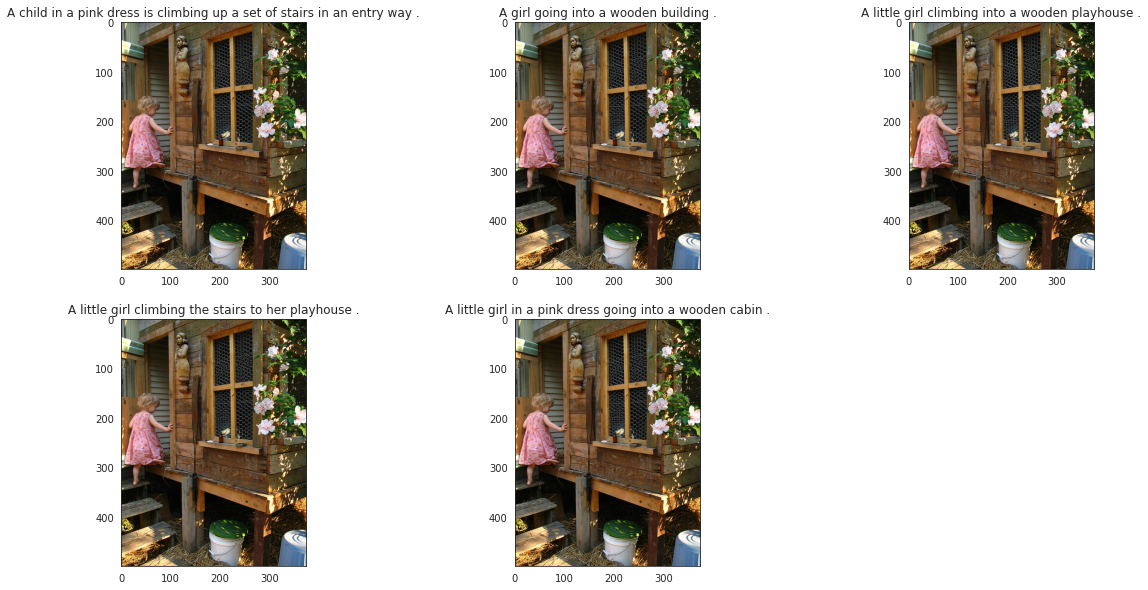

In [8]:
def showCaptionImage(image_name):
    """Show image with its captions"""
    image = plt.imread('./flickr8k/images/' + image_name)
    captions = df_captions.loc[df_captions['image_id'] == image_name].iloc[:, 1]
    
    with sns.axes_style("white"): 
        plt.figure(figsize=(20, 10))
        for i, caption in enumerate(captions):
            fig = plt.subplot(2, 3, i + 1)
            plt.imshow(image)
            plt.title(caption)
    
showCaptionImage('1000268201_693b08cb0e.jpg')

In [9]:
class ImageCaptioningDataset(Dataset):
    """Image captioning dataset"""
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file(string): captions file
            root_dir(string): images directory
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.df_captions = pd.read_csv(csv_file, sep=';')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        """Length is nb_captions / captions_per_image"""
        return len(self.df_captions) / 5
        
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        im_name = self.df_captions.iloc[index, 0]
        im_path = os.path.join(self.root_dir, im_name)
        image = io.imread(im_path)
        
        captions = self.df_captions.loc[self.df_captions['image_id'] == im_name].iloc[:, 1]
        captions = np.array(captions)
        
        sample = {'image': image, 'captions': captions}

        if self.transform:
            sample = self.transform(sample)

        return sample     

In [14]:
# Instanciate train dataset

training_set = ImageCaptioningDataset(
    './flickr8k/annotations/annotations_image_id.csv', 
    './flickr8k/images/train/', 
    transform=transforms.Compose([tr.Rescale(256), tr.RandomCrop(224), tr.Tokenize(), tr.ToTensor()])
)

print(training_set[0])

{'image': tensor([[[0.3205, 0.3889, 0.3159,  ..., 0.0708, 0.0800, 0.0580],
         [0.2884, 0.3556, 0.3383,  ..., 0.1296, 0.1957, 0.2136],
         [0.3035, 0.3749, 0.3679,  ..., 0.1087, 0.1135, 0.1207],
         ...,
         [0.0872, 0.0925, 0.0558,  ..., 0.1475, 0.1345, 0.1434],
         [0.0588, 0.0274, 0.0374,  ..., 0.1423, 0.1255, 0.1586],
         [0.0462, 0.1091, 0.1125,  ..., 0.1285, 0.0876, 0.0913]],

        [[0.2900, 0.3252, 0.2477,  ..., 0.1392, 0.1245, 0.1311],
         [0.2625, 0.3020, 0.2526,  ..., 0.1584, 0.2470, 0.2794],
         [0.2800, 0.3243, 0.2782,  ..., 0.2528, 0.2646, 0.3241],
         ...,
         [0.0541, 0.0749, 0.0597,  ..., 0.1038, 0.1142, 0.1205],
         [0.0508, 0.0353, 0.0394,  ..., 0.0974, 0.0865, 0.1203],
         [0.0509, 0.0762, 0.1048,  ..., 0.0760, 0.0733, 0.0642]],

        [[0.2317, 0.2649, 0.1484,  ..., 0.0369, 0.0189, 0.0005],
         [0.1821, 0.2225, 0.1392,  ..., 0.0464, 0.0609, 0.0825],
         [0.2046, 0.2096, 0.1656,  ..., 0.0838, 